# Pro Cam Scan

## Setup
Notes for setting up on a GCE instance (Ubuntu 16.04). This notebook wont run with the free colab instance

### Connect to GCE instance 

```ssh -i $HOME/.ssh/google_compute_engine jongejan@<IP> -L 8888:localhost:8888 ```

### Setup dependencies:
```
wget https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh
bash Anaconda3-5.2.0-Linux-x86_64.sh
pip install jupyter_http_over_ws
jupyter serverextension enable --py jupyter_http_over_ws
gcloud init
```

### Start
```jupyter notebook   --NotebookApp.allow_origin='https://colab.research.google.com'   --no-browser  --port=8888```



### Upload data:
```gsutil -m rsync -r SharedData/ gs://lightleaks/todaysart/```

Interesting things I noticed:
- Color is a subtle indicator of edge reflections.
- It should be possible to know that the gray area between white and black belongs to both white and black.
- Highpass is only helpful for calculating the confidence, not useful for building the map.

In [0]:
#@title Settings { run: "auto" }

# SETTINGS
proj_width = 4200 #@param {type:"integer"}
proj_height = 1050 #@param {type:"integer"}

bucket = 'lightleaks'
bucket_folder = "todaysart" #@param ["music_center", "todaysart"] {allow-input: true}


In [0]:
!sudo apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!sudo apt-get install -y libturbojpeg  libxrender-dev
!pip install jpeg4py msgpack numpy-indexed

!rm -rf utils
!git clone https://github.com/kylemcdonald/python-utils utils
import cv2
from utils.imutil import *
from utils.progress import *
from utils.show_array import *
from matplotlib import pyplot as plt
from itertools import product
import glob 

# !pip install mpld3
# import matplotlib.pyplot as plt, mpld3
%matplotlib inline

# mpld3.


/bin/bash: sudo: command not found
/bin/bash: sudo: command not found
    100% |████████████████████████████████| 430kB 11.8MB/s 
    100% |████████████████████████████████| 163kB 11.4MB/s 
  Running setup.py bdist_wheel for jpeg4py ... - \ done
  Stored in directory: /root/.cache/pip/wheels/bd/cc/60/4aa01b0f17ef1696af675e44d76c2b6a25abe4f2bdcbc522f8
  Running setup.py bdist_wheel for pycparser ... - \ done
  Stored in directory: /root/.cache/pip/wheels/f2/9a/90/de94f8556265ddc9d9c8b271b0f63e57b26fb1d67a45564511
Successfully built jpeg4py pycparser


In [3]:
data_dir = '/tmp/data/'+bucket_folder
def sync_data():
  !mkdir -p {data_dir}
  !gsutil -m rsync -r -d 'gs://{bucket}/{bucket_folder}' /tmp/data/{bucket_folder}
  
sync_data()

print("Scans:")
!ls -d {data_dir}/scan-*/

Building synchronization state...
Starting synchronization...
Scans:
/tmp/data/todaysart/scan-1249/	/tmp/data/todaysart/scan-1541/
/tmp/data/todaysart/scan-1255/	/tmp/data/todaysart/scan-2137/
/tmp/data/todaysart/scan-1338/	/tmp/data/todaysart/scan-2201/
/tmp/data/todaysart/scan-1512/	/tmp/data/todaysart/scan-2207/
/tmp/data/todaysart/scan-1515/	/tmp/data/todaysart/scan-2210/
/tmp/data/todaysart/scan-1521/	/tmp/data/todaysart/scan-2214/
/tmp/data/todaysart/scan-1524/	/tmp/data/todaysart/scan-2218/
/tmp/data/todaysart/scan-1529/	/tmp/data/todaysart/scan-2222/
/tmp/data/todaysart/scan-1534/	/tmp/data/todaysart/scan-closeup/
/tmp/data/todaysart/scan-1539/


## Image loading

In [4]:
from scipy import ndimage
from multiprocessing import Pool, cpu_count
# !ls -d {data_dir}/scan-*/
_scan_name = 'scan-2137' #@param  {type: "string"}
# !mkdir -p /tmp/scan/
# !gsutil -m -q cp -r 'gs://{bucket}/{scan_name}' /tmp/scan/

def job(fn):
    # faster to do conversion to gray here (in parallel) rather than later
    data = imread(fn).mean(axis=2)
    lowpass = ndimage.gaussian_filter(data, 30)
#     lowpass = ndimage.gaussian_filter(data, 300)
    gauss_highpass = data - lowpass
    gauss_highpass = np.abs(gauss_highpass)
    return gauss_highpass

def load_scan(__scan_name):
  global scan_name, cam_mask_image, normal_horizontal, inverse_horizontal, normal_vertical, inverse_vertical, images
  scan_name = __scan_name
  count_vertical_files_normal = len(glob.glob1(os.path.join(data_dir,scan_name,'cameraImages/vertical/normal'),"*.jpg"))
  count_vertical_files_inverse = len(glob.glob1(os.path.join(data_dir,scan_name,'cameraImages/vertical/inverse'),"*.jpg"))
  count_horizontal_files_normal = len(glob.glob1(os.path.join(data_dir,scan_name,'cameraImages/horizontal/normal'),"*.jpg"))
  count_horizontal_files_inverse = len(glob.glob1(os.path.join(data_dir,scan_name,'cameraImages/horizontal/inverse'),"*.jpg"))

  assert count_vertical_files_normal > 0
  assert count_vertical_files_normal == count_vertical_files_inverse
  assert count_horizontal_files_normal == count_horizontal_files_inverse
  

  # cam_mask_image = 
  try:
    cam_mask_image = imread(os.path.join(data_dir,scan_name,"mask.png"))
    if len(cam_mask_image.shape) == 3:
      cam_mask_image = cam_mask_image.mean(axis=2)
  except:
    cam_mask_image = None
    print("No mask loadeed")

  filenames = []
  descriptions = []
  for direction, n in (('vertical', count_vertical_files_normal), ('horizontal', count_horizontal_files_normal)):
      for parity in ('normal', 'inverse'):
          cur = [(direction, parity, i) for i in range(n)]
          descriptions.extend(cur)
          filenames.extend([os.path.join(data_dir,scan_name,'cameraImages/{}/{}/{}.jpg'.format(*e)) for e in cur])


#   print(count_vertical_files_normal, filenames)
#   images = progress_parallel(job, filenames)
  with Pool(cpu_count()) as pool:
    images = pool.map(job, filenames)

  # Load images in right buckets

  normal_horizontal = np.asarray([i for i,d in zip(images, descriptions) if d[0] == 'horizontal' and d[1] == 'normal'])
  inverse_horizontal = np.asarray([i for i,d in zip(images, descriptions) if d[0] == 'horizontal' and d[1] == 'inverse'])
  normal_vertical = np.asarray([i for i,d in zip(images, descriptions) if d[0] == 'vertical' and d[1] == 'normal'])
  inverse_vertical = np.asarray([i for i,d in zip(images, descriptions) if d[0] == 'vertical' and d[1] == 'inverse'])

  print("Horizontal count: %d" % len(normal_horizontal))
  print("Vertical count: %d" % len(normal_vertical))

load_scan(_scan_name)

Horizontal count: 11
Vertical count: 13


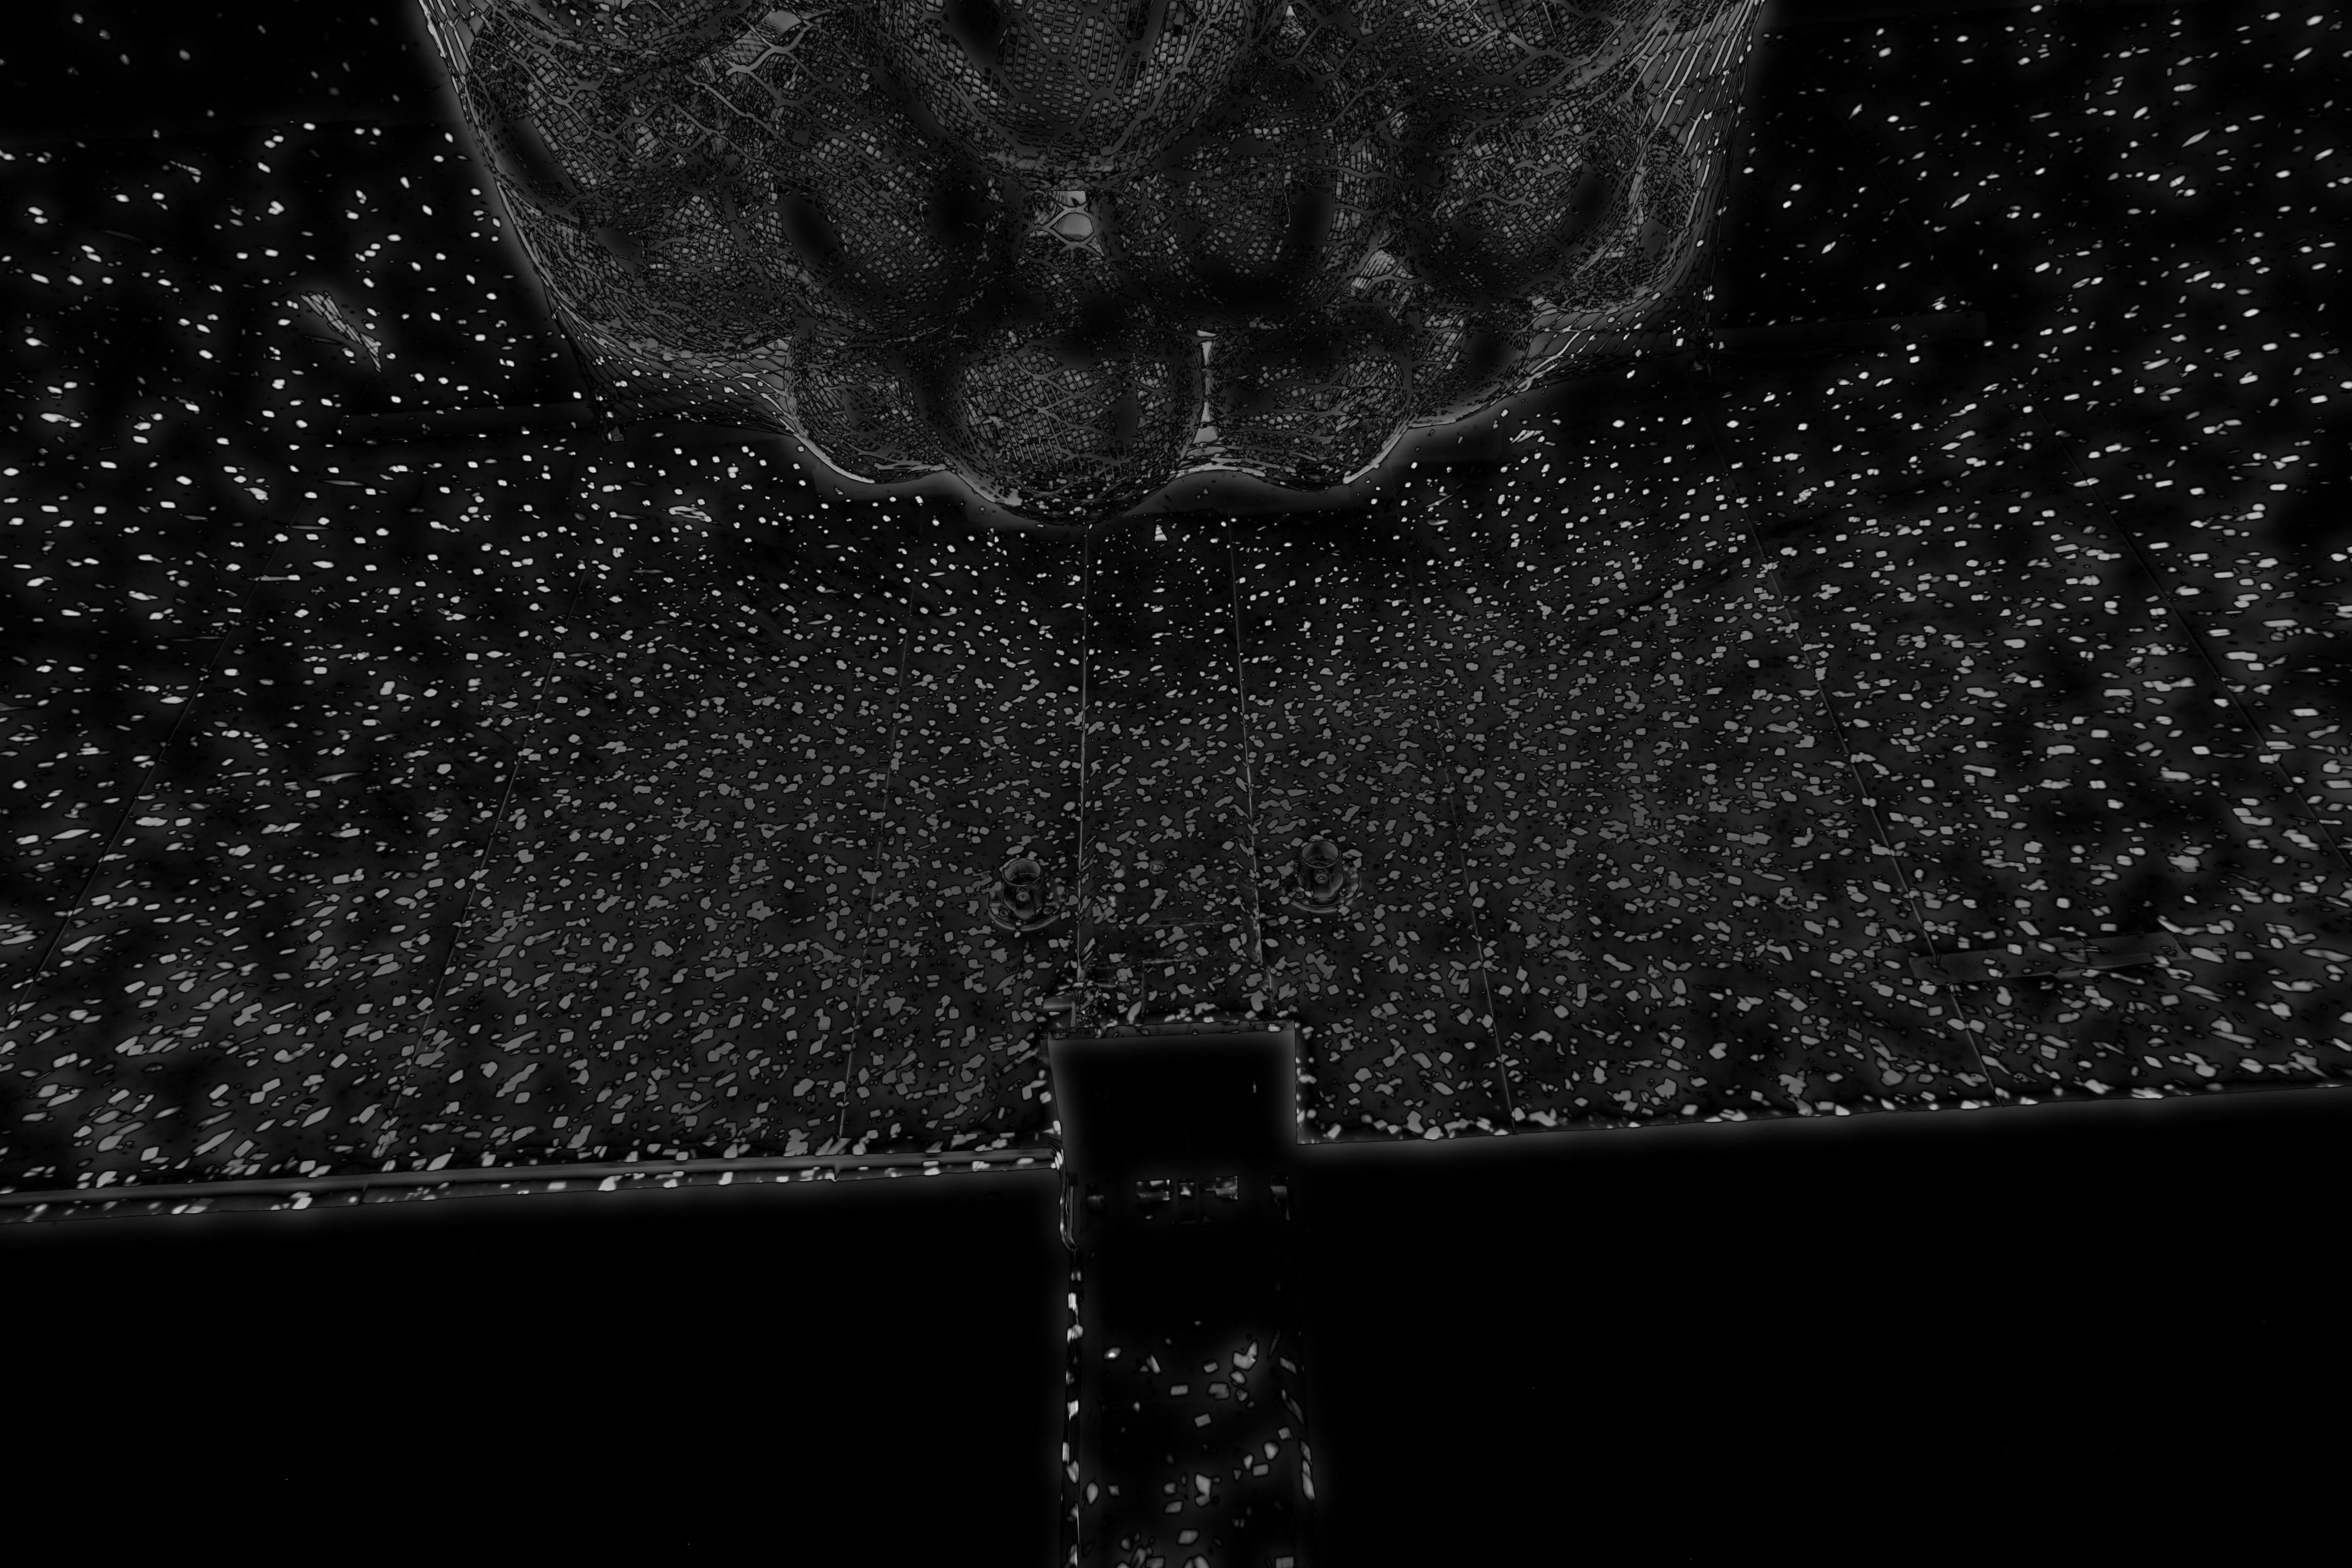

In [5]:

im = normal_horizontal[5]

# print(im.shape, cam_mask_image.shape)
# im[cam_mask_image == 0] = 0
show_array(im, zoom=.4, fmt='jpg')

In [6]:
def calculate_difference():
  global diff_code_horizontal, diff_code_vertical, confidence_horizontal, confidence_vertical
  global confidence
  # Calculate differeence
  diff_code_horizontal = normal_horizontal.astype(np.float32) - inverse_horizontal.astype(np.float32)
  diff_code_vertical = normal_vertical.astype(np.float32) - inverse_vertical.astype(np.float32)

  confidence_horizontal = np.sum(np.abs(diff_code_horizontal), axis=0) // len(diff_code_vertical)
  confidence_vertical = np.sum(np.abs(diff_code_vertical), axis=0) // len(diff_code_horizontal)

  # Another approach: Minimal confidence score (except highest frquency)
  # confidence_horizontal = np.min(np.abs(diff_code_horizontal[5:6]), axis=0) 
  # confidence_vertical = np.min(np.abs(diff_code_vertical[5:6]), axis=0) 

  confidence_vertical /=  256.0
  confidence_horizontal /=  256.0

  confidence = np.mean((confidence_horizontal, confidence_vertical), axis=0)

  confidence[cam_mask_image == 0] = 0
  confidence_raw = confidence

  # std = (np.std(np.abs(diff_code_horizontal), axis=0) + np.std(np.abs(diff_code_vertical), axis=0)) / 512
  # std = (np.std(np.abs(diff_code_horizontal), axis=0) ) / 256
  # print("Std: ",std.max())
  # confidence = std * confidence


calculate_difference()
print("Max confidence:", confidence.max())
print("Max confidence vertical:", confidence_vertical.max(), "mean", confidence_vertical.mean())
print("Max confidence horizontal:", confidence_horizontal.max(), "mean", confidence_horizontal.mean())
print(confidence.shape)


Max confidence: 0.7832031
Max confidence vertical: 0.921875 mean 0.07349998
Max confidence horizontal: 0.64453125 mean 0.05128646
(3456, 5184)


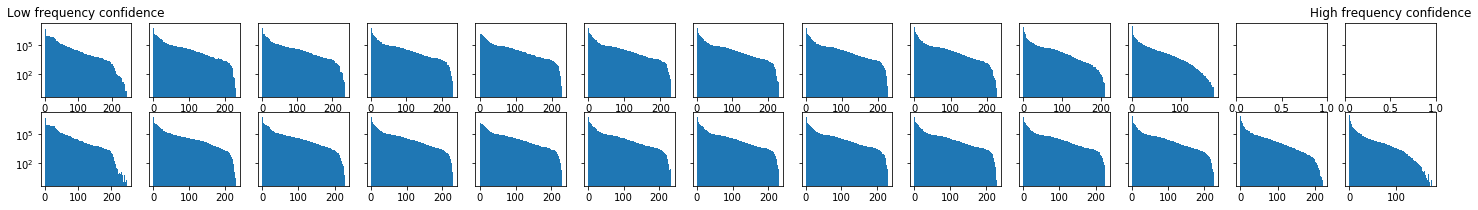

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=len(diff_code_vertical), figsize=(25, 3), sharey=True)
for i, d in enumerate(diff_code_horizontal):
  ax[0][i].hist(np.abs(d.flatten()), bins=100)
  ax[0][i].set_yscale('log')
  
for i, d in enumerate(diff_code_vertical):
  ax[1][i].hist(np.abs(d.flatten()), bins=100)
  ax[1][i].set_yscale('log')
  
ax[0][0].set_title('Low frequency confidence')
ax[0][-1].set_title('High frequency confidence')

plt.show()

(array([8., 4., 1., 0., 0., 1., 1., 0., 7., 2.]),
 array([-137.97750854, -109.76806793,  -81.55862732,  -53.34918671,
         -25.13974609,    3.06969452,   31.27913513,   59.48857574,
          87.69801636,  115.90745697,  144.11689758]),
 <a list of 10 Patch objects>)

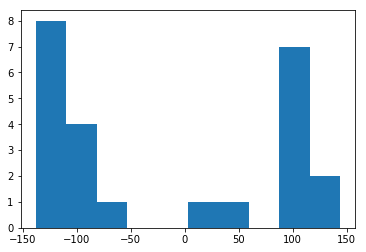

In [8]:


diff_code = np.vstack((diff_code_horizontal, diff_code_vertical))

p = diff_code[:,1500,1000]

plt.hist(p.flat, bins=10)

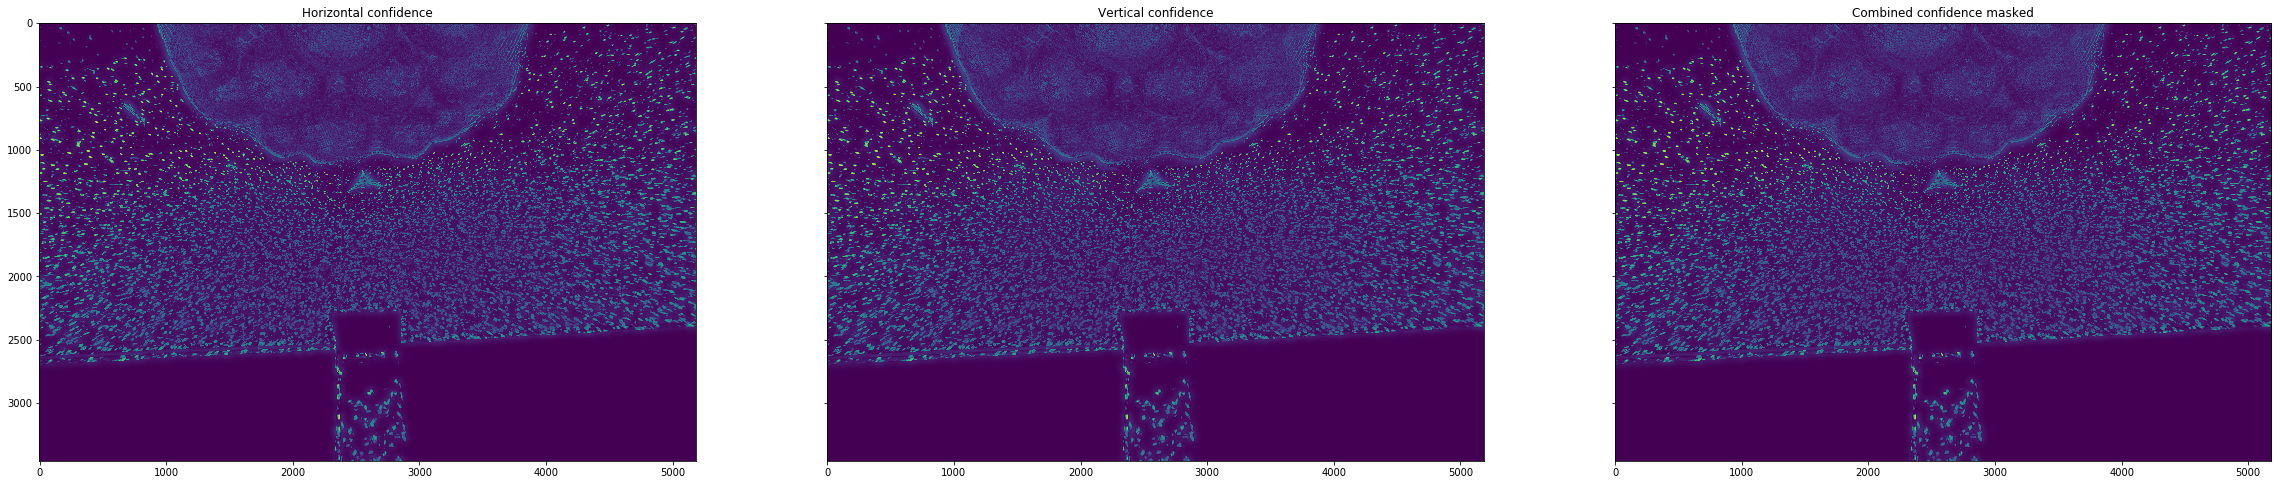

In [9]:

%matplotlib inline 
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(40, 20), sharey=True)
ax1.imshow(confidence_horizontal, cmap='viridis')
ax1.set_title('Horizontal confidence')
ax2.imshow(confidence_vertical, cmap='viridis')
ax2.set_title('Vertical confidence')

ax3.imshow(confidence, cmap='viridis')
ax3.set_title('Combined confidence masked')

plt.show()

In [0]:
# show_array(confidence_horizontal*256)

# show_array(256 * std, zoom=0.3)
# show_array(confidence_raw * 256, zoom=0.3)



## Binary packing

In [0]:
# Binary packing
def pack_raw(channels, dtype=np.uint16):
    packed = (channels > 0).astype(dtype)
    n = len(packed)
    for i in range(n):
        packed[i] <<= n - i - 1
    return packed.sum(axis=0).astype(dtype)

def gray_to_binary(packed, n, dtype=np.uint16):
    codes = 1 << n
    lut = np.zeros(codes)
    for binary in range(codes):
        gray = (binary >> 1) ^ binary
        lut[gray] = binary
    return lut[packed].astype(dtype)

def pack_binary(channels, dtype=np.uint16):
    return gray_to_binary(pack_raw(channels, dtype), len(channels), dtype)
        

In [0]:
def run_pack():
  global packed_horizontal, packed_vertical, packed
  packed_horizontal = pack_binary(diff_code_horizontal)
  packed_vertical = pack_binary(diff_code_vertical)

  # packed_vertical[cam_mask_image == 0] = 0
  # packed_horizontal[cam_mask_image == 0] = 0

  # packed = np.dstack((packed_vertical, packed_horizontal, np.zeros_like(packed_horizontal)))
  packed = np.dstack((packed_vertical, packed_horizontal))
  packed.shape
run_pack()

In [0]:
# imwrite('binaryCoded-python.png', packed)

In [13]:

im = np.dstack((packed, np.zeros_like(packed_horizontal))) 
max_binary_code = im.max(axis=(0,1))
max_binary_code[2] = 1
# print(max_binary_code)
im = im / max_binary_code
print(im.shape)
# im *= confidence[:,:,np.newaxis]
show_array(im * 256, zoom=0.3, fmt='jpg')
show_array(im * 256 * confidence[:,:,np.newaxis], zoom=0.3, fmt='jpg')

In [14]:
# im = np.dstack((packed, np.zeros_like(packed_horizontal))) 
# grid = im.copy()
# print(grid[:,:,0])
# grid[(grid[:,:,0]) % 1 < 0.5] = [1.0, 0.0, 1.0]

show_array((im % 8) * 64, zoom=1.0, fmt='jpg')

# from scipy import ndimage

# data = packed / packed.max()
# lowpass = ndimage.gaussian_filter(data, 3)
# gauss_highpass = data - lowpass
# gauss_highpass = np.abs(gauss_highpass)

# print(gauss_highpass.min(), gauss_highpass.max())
# gauss_highpass -= gauss_highpass.min()
# gauss_highpass /= gauss_highpass.max()

# print(gauss_highpass.min(), gauss_highpass.max())


# show_array(255*gauss_highpass.mean(axis=-1),zoom=0.3, fmt='jpg')

# plt.hist(gauss_highpass.flat)


In [15]:
d = np.diff(packed, axis=0, n=1)[:3450, :5180]# +  np.diff(packed, axis=1, n=1)[:3450, :5180]
# print(d.mean(axis=(2)).shape)
# d = d.sum(axis=2)
d = d[:,:,0]
# print(d.max(), d.shape)
# d[d>8000] = 8000
show_array(d)

In [16]:
show_array(confidence * 256, zoom=0.3)


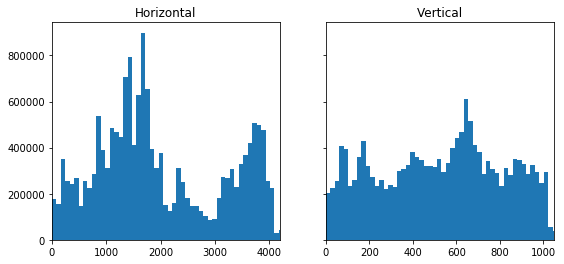

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)

ax1.hist(packed[:,:,0].flat, bins=100)
ax1.set_xlim([0, proj_width])
ax1.set_title("Horizontal")

ax2.hist(packed[:,:,1].flat, bins=100)
ax2.set_xlim([0, proj_height])
ax2.set_title("Vertical")
plt.show()

## Build pro map

In [0]:
# Build Pro Map
from numba import jit

def add_channel(x):
    return np.pad(x, pad_width=((0,0),(0,0),(0,1)), mode='constant', constant_values=0)

@jit('uint16(uint16[:], uint16[:], uint16[:], int64, int64)')
def build_pro_map(packed_vertical, packed_horizontal, confidence, w, h):
    packed_vertical = np.minimum(packed_vertical, w-1)
    packed_horizontal = np.minimum(packed_horizontal, h-1)
    cam_map = np.dstack((packed_horizontal, packed_vertical))

    pro_map = np.zeros((h,w,2), dtype=np.uint16)
    pro_confidence = np.zeros((h,w), dtype=np.float32)
    
    for i in range(cam_map.shape[0]):
        for j in range(cam_map.shape[1]):
            idx = cam_map[i,j]
            pconf = confidence[i,j]
            # (j, i) should probably be swapped, but
            # this is how it was done in c++
            if pconf > 0 and pconf > pro_confidence[idx[0], idx[1]]:
              pro_map[idx[0], idx[1]] = (j, i)
              pro_confidence[idx[0], idx[1]] = pconf
    return (add_channel(pro_map), pro_confidence)


In [22]:
def run_build_promap():
  global pro_map, pro_confidence
  (pro_map, pro_confidence) = build_pro_map(packed_vertical, packed_horizontal, confidence, proj_width, proj_height)

run_build_promap()
print(pro_confidence.shape)

(1050, 4200)


In [23]:
def render_result():
  mc = pro_confidence.max()
  mm = pro_map.max(axis=(0,1))
  mm[2] = 1

#   print(mc)

  im = (256, 256, 256) * pro_map / mm
  show_array(pro_confidence * 256 / mc, zoom=.2, fmt='jpg')
  show_array(im, zoom=0.2, fmt='jpg')
  show_array(im * pro_confidence[:,:,np.newaxis] * (1./mc), zoom=0.3, fmt='jpg')
  
render_result()


## Store results

In [24]:
def store_results():
#   print(pro_confidence.dtype)
  # Store results
  imwrite('proMap-python.png', pro_map)
  imwrite('proConfidence-python.exr', pro_confidence)
  imwrite('camConfidence-python.exr', confidence)
  
#   im = np.dstack((packed, np.zeros_like(packed_horizontal))) 
#   imwrite('camBinary.exr', im)
  np.save('camBinary-python.npy', packed)
  
  !gsutil cp proMap-python.png gs://{bucket}/{bucket_folder}/{scan_name}/
  !gsutil cp proConfidence-python.exr gs://{bucket}/{bucket_folder}/{scan_name}/
  !gsutil cp camConfidence-python.exr gs://{bucket}/{bucket_folder}/{scan_name}/
  !gsutil cp camBinary-python.npy gs://{bucket}/{bucket_folder}/{scan_name}/
    
store_results()

Copying file://proMap-python.png [Content-Type=image/png]...
-
Operation completed over 1 objects/12.4 MiB.                                     
Copying file://proConfidence-python.exr [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/4.6 MiB.                                      
Copying file://camConfidence-python.exr [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/12.9 MiB.                                     
Copying file://camBinary-python.npy [Content-Type=application/octet-stream]...
/
Operation completed over 1 objects/68.3 MiB.                                     


## Run it all!

In [27]:
import re
folders = sorted([f for f in os.listdir(data_dir) if re.match(r'^scan-', f)])
print(folders)
folders = folders[13:]
# folders = ['scan-2201']
print(folders)
# asdasd
for folder in folders:
  print(folder)
  print('load')
  %time load_scan(folder)
  print('calculate diff')
  %time calculate_difference()
  print('run pack')
  %time run_pack()
  print('build promap')
  %time run_build_promap()
  %time render_result()
  print('store')
  %time store_results()
  

## Analysis

In [0]:
# x_max = 1<<len(diff_code_vertical)
# y_max = 1<<len(diff_code_horizontal)

# %time packed[:,:,0] = np.min(packed[:,:,0], x_max)
# %time packed[:,:,1] = np.min(packed[:,:,1], y_max)

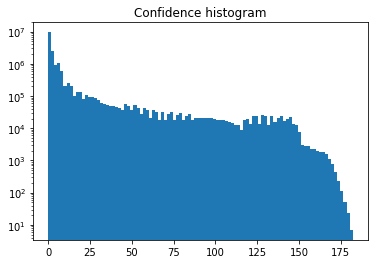

In [47]:
plt.hist(confidence.flat, bins=100)
plt.yscale('log')
plt.title("Confidence histogram")
plt.show()

In [0]:
def get_subset(img, r=128):
    h,w = img.shape[:2]
    h//=2
    w//=2
    subset = np.copy(img[h-r:h+r, w-r:w+r])
    return subset

In [31]:
diff_code = diff_code_vertical
%time subsets = np.asarray([get_subset(e) for e in diff_code])

CPU times: user 6.99 ms, sys: 0 ns, total: 6.99 ms
Wall time: 5.38 ms


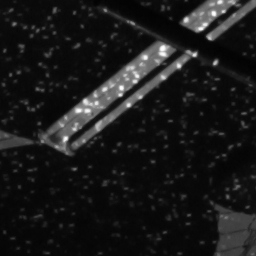

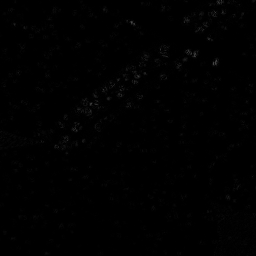

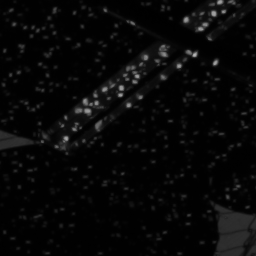

In [32]:
show_array(np.max(np.abs(subsets), axis=0))#//2+128)
show_array(np.min(np.abs(subsets), axis=0))#//2+128)
show_array(np.mean(np.abs(subsets), axis=0))#//2+128)

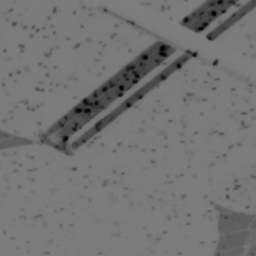

In [24]:
subset = get_subset(diff_code[0])
show_array(subset//2+128)

In [25]:
colors = subset.reshape(-1,3)
plt.figure(figsize=(5,5))
plt.plot([-255,255],[-255,255])
plt.scatter(colors[:,0], colors[:,2], lw=0, s=1, marker='.')
plt.xlim(-255, +255)
plt.ylim(-255, +255)
plt.show()

ValueError: ignored

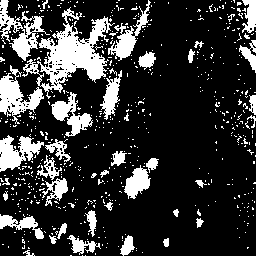

In [108]:
show_array(255 * (subset > 0))

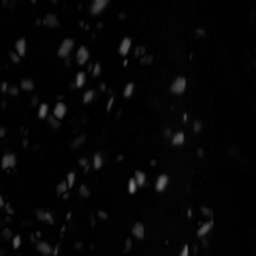

In [44]:
confidence = np.abs(subset)
show_array(confidence)

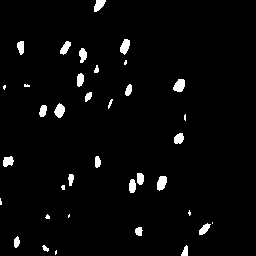

In [111]:
show_array(255 * (confidence > 40))

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=len(diff_code), figsize=(25, 3), sharey=True)

for i, d in enumerate(diff_code):
  ax[i].hist(d.flatten(), bins=100)
  ax[i].set_yscale('log')
plt.show()

<IPython.core.display.Javascript object>

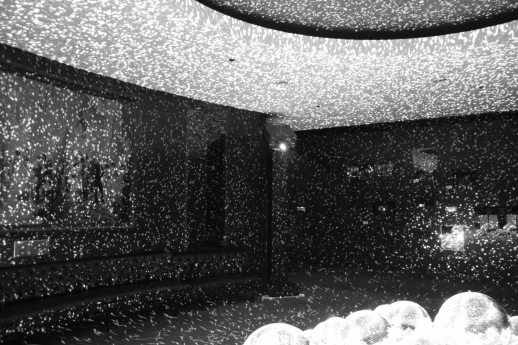

In [125]:
show_array(imresize(images[1], .1))

In [0]:
subsets = []
for img in images:
    h,w = img.shape[:2]
    r = 64
    h//=2
    w//=2
    subset = np.copy(img[h-r:h+r, w-r:w+r])
    subset = subset.astype(np.float)
    subset -= subset.min()
    subset *= 255 / subset.max()
    subsets.append(subset)

In [0]:
diffs = []
for a, b in product(subsets, subsets):
    diff = np.abs(a.astype(np.int32) - b.astype(np.int32)).mean()
    diffs.append(diff)
diffs = np.asarray(diffs)

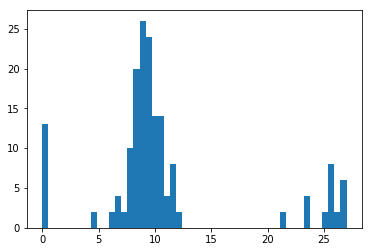

In [37]:
plt.hist(diffs, bins=50)
plt.show()

38.14813232421875 0 26


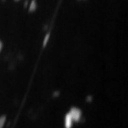

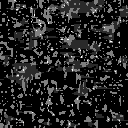

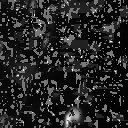

41.48297119140625 1 26


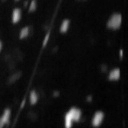

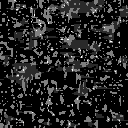

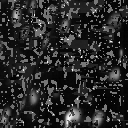

41.39300537109375 2 26


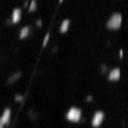

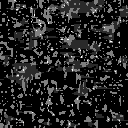

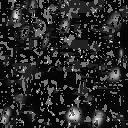

39.7281494140625 3 26


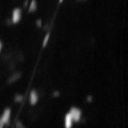

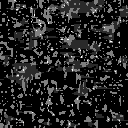

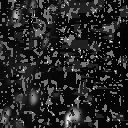

38.894775390625 4 26


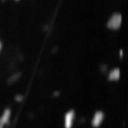

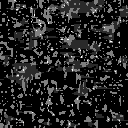

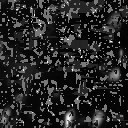

39.0631103515625 5 26


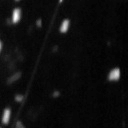

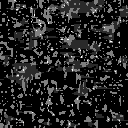

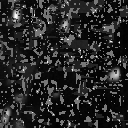

37.50091552734375 6 26


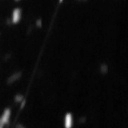

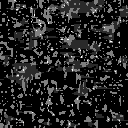

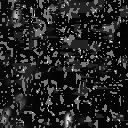

38.39697265625 7 26


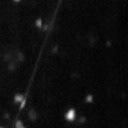

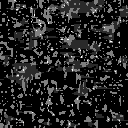

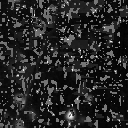

39.68670654296875 8 26


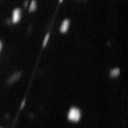

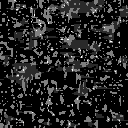

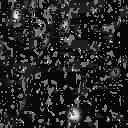

40.472900390625 9 26


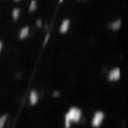

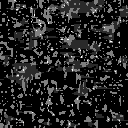

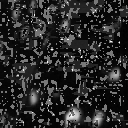

38.813720703125 10 26


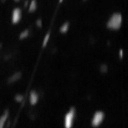

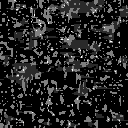

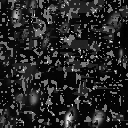

In [98]:
t = 0
for diff, ((i,a),(j,b)) in zip(diffs, product(enumerate(subsets), enumerate(subsets))):
    if diff > 20:
        print(diff, i, j)
        show_array(a)
        show_array(b)
        show_array(np.abs(a.astype(np.int32) - b.astype(np.int32)))
        t += 1
        if t > 10:
            break

# Build XYZ

In [168]:
%matplotlib inline


sync_data()
# #Download data
# procams_folder = '/tmp/procams/'
# # !rm -rf {procams_folder}
# !mkdir -p {procams_folder}
# # !gsutil -m cp -r gs://{bucket}/processedScans/* {procams_folder}
# !gsutil -m rsync -r gs://{bucket}/ {procams_folder}
!ls {data_dir}

Building synchronization state...
Starting synchronization...
BuildXYZDebug.png    model.dae	scan-1512  scan-1529  settings.json
confidenceMap-0.exr  scan-1249	scan-1515  scan-1534  shader
_mask-0.png	     scan-1255	scan-1521  scan-1539  SharedData
mask-0.png	     scan-1338	scan-1524  scan-1541  xyzMap-0.exr


In [169]:
def loadScan(name):
  print("Process",name)
#   print(os.path.join(data_dir, name, 'proMap-python.png'))
  proMap = imread(os.path.join(data_dir, name, 'proMap-python.png'))[:, :, :2]
  proConfidence = imread(os.path.join(data_dir, name, 'proConfidence-python.exr'))
#   proMap = imread(os.path.join(data_dir, name, 'proMap.png'))[:, :, :2]
#   proConfidence = imread(os.path.join(data_dir, name, 'proConfidence.exr'))
  xyzMap = imread(os.path.join(data_dir, name, 'xyzMap.exr'))
  scale = 4
  try:
    scale = images[0].shape[0] / xyzMap.shape[0]
  except NameError:
    print("Using hardcoded scale",scale)

  xyzMap = upsample(xyzMap, scale=scale)
  return (proMap, proConfidence, xyzMap)
  

proMaps = []
proConfidences = []
xyzMaps = []


# folders = os.listdir(data_dir)
folders = [
    "scan-1512",
    "scan-1515",
    "scan-1521",
    "scan-1524",
    "scan-1529",
    "scan-1534",
    "scan-1539",
    "scan-1541"    
]
for folder in folders:
#   try:
    (proMap, proConfidence, xyzMap) = loadScan(folder)
    proMaps.append(proMap)
    proConfidences.append(proConfidence)
    xyzMaps.append(xyzMap)
#   except:
#     print("Could not load ",folder)
  
proMaps = np.asarray(proMaps)
proConfidences = np.asarray(proConfidences)
xyzMaps = np.asarray(xyzMaps)

print(proMaps.shape)
print(proConfidences.shape)
  

Process scan-1512
Process scan-1515
Process scan-1521
Process scan-1524
Process scan-1529
Process scan-1534
Process scan-1539
Process scan-1541
(8, 1050, 4200, 2)
(8, 1050, 4200)


In [0]:
# print(np.dstack((proMaps[0], np.zeros(proMaps[0].shape[0], proMaps[0].shape[1]) )).shape)
# plt.imshow(proMap[1])
# mpld3.display()


Text(0.5,1,'Confidence thresholded')

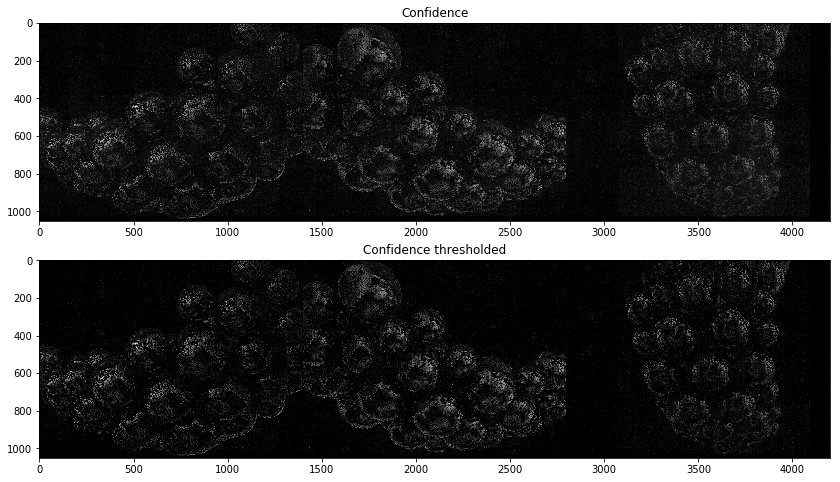

In [170]:
confidence_threshold = 0.1 #@param

proConfidencesThresholded = proConfidences.copy()
mask = proConfidencesThresholded > confidence_threshold
proConfidencesThresholded[ mask == 0 ] = 0


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharey=True)
ax1.imshow(proConfidences.mean(axis=0), cmap='gray')
ax1.set_title('Confidence')

ax2.imshow(proConfidencesThresholded.mean(axis=0), cmap='gray')
ax2.set_title('Confidence thresholded')

  
# mpld3.display()

In [171]:
# print(xyzMaps.shape)
num_scans = xyzMaps.shape[0]

xyzFlat = xyzMaps.reshape(( -1, 3))

x = proMaps[:,:,:, 0].reshape((-1))
y = proMaps[:,:,:, 1].reshape((-1))
z = np.indices(proMaps.shape[0:3])[0].reshape((-1))
# print(z[0])


assert x.max() == xyzMaps.shape[2] - 1
assert y.max() == xyzMaps.shape[1] - 1

lut_indexes = np.ravel_multi_index((z, y, x), xyzMaps.shape[0:3], order="C")
# lut_indexes_reshaped = lut_indexes.reshape((num_scans, -1))

# plt.plot(lut_indexes)
# print(lut_indexes.max())

proXyzMaps = xyzFlat[lut_indexes]

proXyzMaps = proXyzMaps.reshape((num_scans, proMaps.shape[1], -1, 3))

# plt.imshow(proXyzMap[1])

# print("Max: ")
# print(proXyzMaps.max(axis=(1,2)))
# print("Min: ")
# print(proXyzMaps.min(axis=(1,2)))

proXyzMapsThresholded = proXyzMaps * (proConfidences[:,:,:,np.newaxis] > confidence_threshold)

for a in proXyzMapsThresholded:
  show_array(a * (256/proXyzMapsThresholded.max()), zoom=0.1, fmt='jpg')
# mpld3.display()

In [172]:
from scipy.spatial import distance

meanPoint = np.mean(xyzMaps, axis=(1,2))
print("Mean point", meanPoint)

distances = np.zeros(proXyzMaps.shape[0:3])[:,:,:,np.newaxis]

for i, proXyzMap in enumerate(proXyzMapsThresholded):
  xyzFlat = proXyzMap.reshape((-1, 3))
  d = distance.cdist(xyzFlat, [meanPoint[i]])
  d = d.reshape((proXyzMaps.shape[1], proXyzMaps.shape[2], 1))
  distances[i] = d
  

# fig, ax = plt.subplots(nrows=num_scans, ncols=1, figsize=(30, 10), sharey=True)
# for i, distance in enumerate(distances):
#   ax[i].imshow(-distance[:,:,0], cmap='jet')

# plt.show()

Mean point [[0.4215107  0.27456006 0.17913911]
 [0.46438938 0.40417594 0.4289511 ]
 [0.4682213  0.45458183 0.16154972]
 [0.46854377 0.45572487 0.436339  ]
 [0.26011527 0.4128531  0.1411341 ]
 [0.2643873  0.4173779  0.43674812]
 [0.26233226 0.34810546 0.15326512]
 [0.29445907 0.3766263  0.41686526]]


In [173]:
dominant_scans_index = np.argmin(distances, axis=0).reshape(-1)

transposed = proXyzMapsThresholded.transpose((1,2,0,3)).reshape((-1, num_scans, 3))

print(distances.shape, proXyzMapsThresholded.shape, dominant_scans_index.shape, transposed.shape)

proXyzMapCombined = transposed[range(transposed.shape[0]), dominant_scans_index].reshape(proXyzMapsThresholded[0,:,:].shape)

show_array(proXyzMapCombined* (256/proXyzMapsThresholded.max()), zoom=0.3, fmt="jpg")

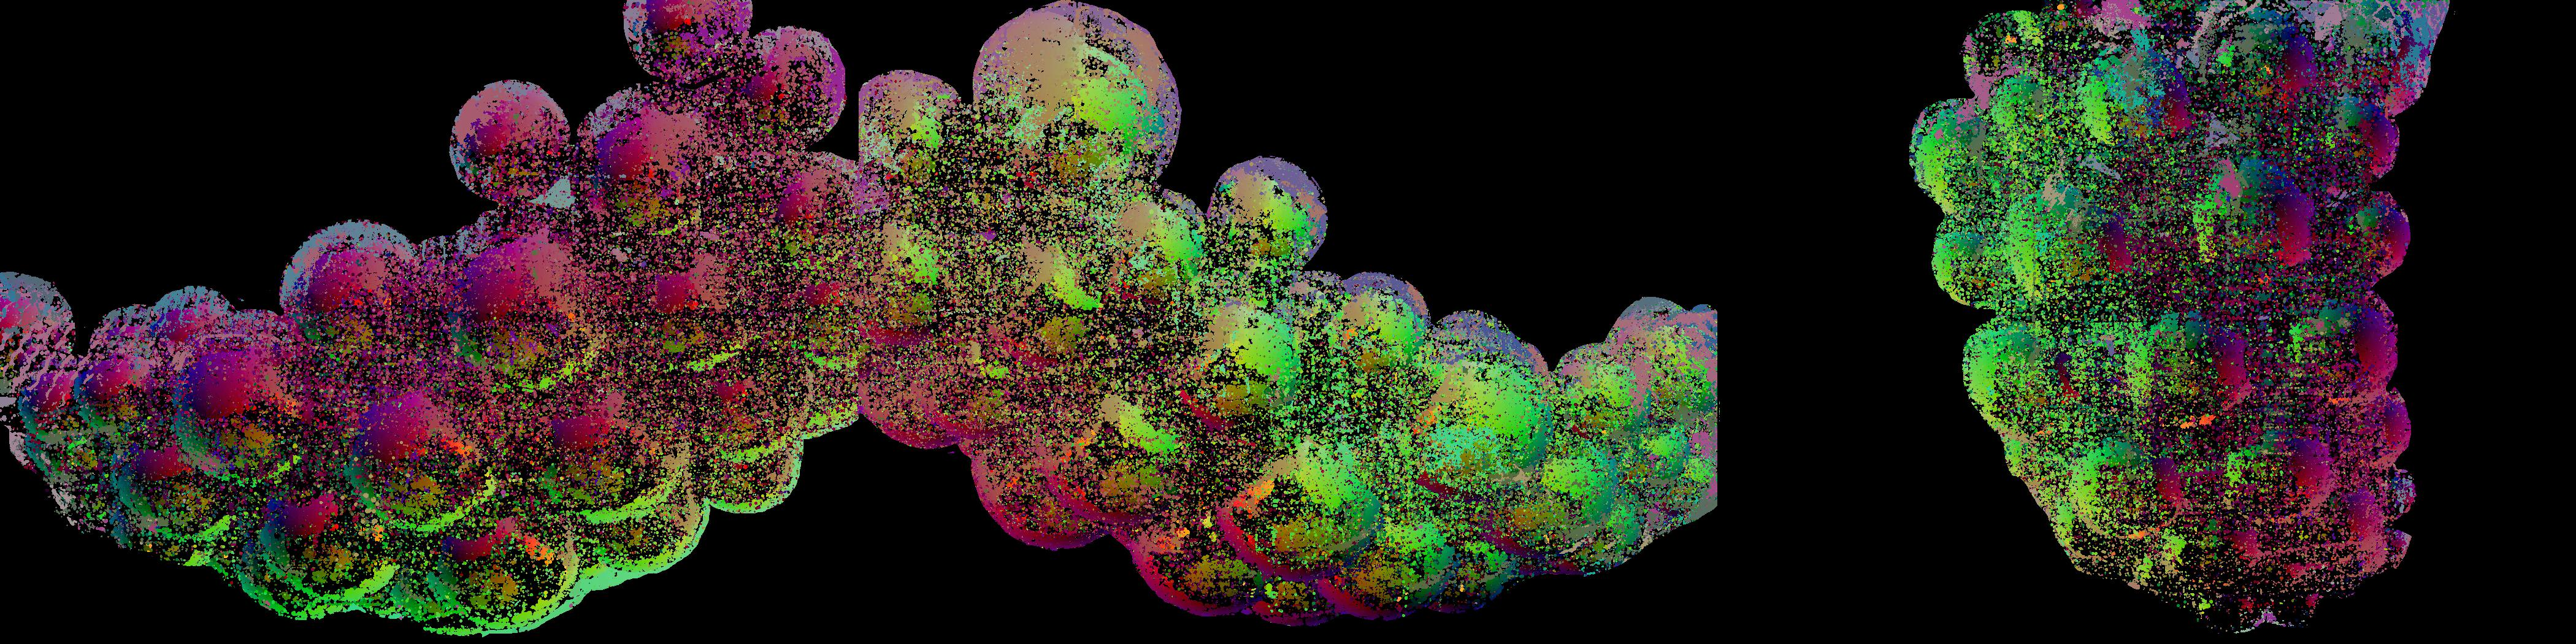

In [299]:
validation_image = imread('/tmp/data/todaysart/xyzMap-0.exr')
show_array(validation_image * (256/proXyzMapsThresholded.max()), zoom=0.3, fmt="jpg")

# Build XYZ V2
## Load

In [37]:
sync_data()
!ls {data_dir}

Building synchronization state...
Starting synchronization...
Copying gs://lightleaks/todaysart/.DS_Store...
Copying gs://lightleaks/todaysart/BuildXYZDebug.png...
Copying gs://lightleaks/todaysart/confidenceMap-0.exr...
Copying gs://lightleaks/todaysart/mask-0.png...
Copying gs://lightleaks/todaysart/xyzMap-0-old.exr...
Copying gs://lightleaks/todaysart/xyzMap-0.exr...
- [6/6 files][ 21.6 MiB/ 21.6 MiB] 100% Done                                    
Operation completed over 6 objects/21.6 MiB.                                     
BuildXYZDebug.png	    scan-1338  scan-1541  scan-closeup
confidenceMap-0.exr	    scan-1512  scan-2137  settings.json
confidenceMap-python-0.exr  scan-1515  scan-2201  shader
_mask-0.png		    scan-1521  scan-2207  SharedData
mask-0.png		    scan-1524  scan-2210  xyzMap-0.exr
model.dae		    scan-1529  scan-2214  xyzMap-0-old.exr
scan-1249		    scan-1534  scan-2218  xyzMap-python-0.exr
scan-1255		    scan-1539  scan-2222


In [29]:
def loadScan(name):
  print("Process",name)
  xyzMap = imread(os.path.join(data_dir, name, 'xyzMap.exr'))
  camBinary = np.load(os.path.join(data_dir, name, 'camBinary-python.npy'))
  camConfidence = imread(os.path.join(data_dir, name, 'camConfidence-python.exr'))
  scale = camBinary.shape[0] / xyzMap.shape[0]
  
  xyzMap = upsample(xyzMap, scale=scale)
  return (camBinary, camConfidence, xyzMap)
  

camBinaries = []
xyzMaps = []
camConfidences = []


# folders = os.listdir(data_dir)
folders = [
    "scan-1512",
    "scan-1515",
    "scan-1521",
    "scan-1524",
    "scan-1529",
    "scan-1534",
    "scan-1539",
    "scan-1541",
    "scan-2137",
    "scan-2201",
    "scan-2207",
    "scan-2210",
    "scan-2214",
    "scan-2218",
    "scan-2222",
#     "scan-1539",
#     "scan-1539",
]
for folder in folders:
#   try:
    (camBinary, camConfidence, xyzMap) = loadScan(folder)
    camBinaries.append(camBinary)
    camConfidences.append(camConfidence)
    xyzMaps.append(xyzMap)
#   except:
#     print("Could not load ",folder)
  
camBinaries = np.asarray(camBinaries)
xyzMaps = np.asarray(xyzMaps)
camConfidences = np.asarray(camConfidences)

print(camBinaries.shape)
print(camConfidences.shape)
print(xyzMaps.shape)

Process scan-1512
Process scan-1515
Process scan-1521
Process scan-1524
Process scan-1529
Process scan-1534
Process scan-1539
Process scan-1541
Process scan-2137
Process scan-2201
Process scan-2207
Process scan-2210
Process scan-2214
Process scan-2218
Process scan-2222
(15, 3456, 5184, 2)
(15, 3456, 5184)
(15, 3456, 5184, 3)


## Stack and sort

In [0]:
# camConfidences, camBinaries, worldXyzMaps
# Calculate proj index

binaryFlat = camBinaries.reshape(( -1, 2))
# Overflow fix
binaryFlat[(binaryFlat[:,0] >= proj_width) | (binaryFlat[:,1] >= proj_height)] = [0,0]

camProjIndex = np.ravel_multi_index(binaryFlat.transpose()[::-1], (proj_height, proj_width), order="C")
camProjIndex = camProjIndex.reshape(camBinaries.shape[0:3])
# print("max", camProjIndex.max())
# print(camProjIndex.shape, camConfidences.shape, worldXyzMaps.shape)
# Stack proj index with confidence 
stack = np.stack((camConfidences, camProjIndex), axis=-1)
# print(stack.shape, worldXyzMaps.shape)
stack = np.vstack((stack.transpose(), xyzMaps.transpose())).transpose()
# print(stack)

flatStack = stack.reshape(-1, stack.shape[-1])
sortedStack = flatStack[flatStack[:,0].argsort()[::-1]]
# print(flatStack.shape)

In [33]:
print(sortedStack.transpose()[1].shape)
%time (u, indexes,  counts) = np.unique(sortedStack.transpose()[1].astype(np.uint32), return_index=True, return_counts=True, return_inverse=False)
print(u, indexes)

(268738560,)
CPU times: user 1min 51s, sys: 8.83 s, total: 2min
Wall time: 1min 45s
[      0       1       2 ... 4409996 4409998 4409999] [  1734270  43754419  29045044 ... 261787230 248814462 253807847]


## Combine

In [34]:
# print(sortedStack.transpose()[1].astype(np.uint32).shape, u.shape)
# filtered_u = u[(u[:,0] < proj_width) & (u[:,1] < proj_height)]
# filtered_counts = counts[(u[:,0] < proj_width) & (u[:,1] < proj_height)]
# filtered_indexes = indexes[(u[:,0] < proj_width) & (u[:,1] < proj_height)]

# uu = filtered_u.transpose()[::-1]

# print(uu[::-1])
# print(uu, (proj_height, proj_width))
# lut_u = np.ravel_multi_index(uu, (proj_height, proj_width), order="C")
# print(lut_indexes)
counts[0] = 0
# print(u.shape, filtered_counts.shape)
pro = np.zeros((proj_height, proj_width, 3))
proConfidence = np.zeros((proj_height, proj_width, 1))
# print(u, counts)
print(sortedStack[indexes][:,2:].shape)
pro.reshape(-1, 3)[u] = sortedStack[indexes][:,2:]
proConfidence.reshape(-1)[u] = sortedStack[indexes][:,0]
# print(pro.mean())
# print(camProjIndex.max())

# print(filtered_counts)
show_array(proConfidence * pro / pro.max() * 255  , zoom=0.5)

# pro[proConfidence < 0.1] = [0,0,0]
# show_array( pro / pro.max() * 255  , zoom=0.5)
# show_array(proConfidence * 128, zoom=0.5)
# show_array(pro / pro.max() * 255  , zoom=0.3)


In [0]:
projMask = imread(os.path.join(data_dir, 'mask-0.png')).mean(axis=2) / 255

proConfidenceMasked = proConfidence * projMask[:,:,np.newaxis]



## Store



In [39]:
# print(pro.dtype,  proConfidenceMasked[:,:,0].shape)
# 
imwrite('xyzMap-python-0.exr', pro.astype(np.float32))
imwrite('confidenceMap-python-0.exr', proConfidenceMasked.astype(np.float32))

!gsutil cp xyzMap-python-0.exr gs://{bucket}/{bucket_folder}/
!gsutil cp confidenceMap-python-0.exr gs://{bucket}/{bucket_folder}/


Copying file://xyzMap-python-0.exr [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/35.6 MiB.                                     
Copying file://confidenceMap-python-0.exr [Content-Type=application/octet-stream]...
/ [1 files][  4.2 MiB/  4.2 MiB]                                                
Operation completed over 1 objects/4.2 MiB.                                      


In [167]:
# print(filtered_indexes.shape, filtered_u.shape)

# # lut_indexes = np.ravel_multi_index(uu, (proj_height, proj_width), order="C")
# pro = np.zeros((proj_height, proj_width, 3))
# print(pro.reshape(-1)[lut_u].shape)
# pos = worldXyzMaps[filtered_indexes]
# # print(pos.shape)
# pro.reshape(-1, 3)[lut_u] = pos  

# show_array(pro / pro.max() * 256, zoom=0.3)

